In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.datasets import mnist

from optimizers import GradientDescent, Nesterov, Adam,LBFGS


In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[(y_train == 1) | (y_train == 7)].reshape(
    (-1, np.prod(X_train.shape[1:]))) / 255.
y_train = 2 * (y_train[(y_train == 1) | (y_train == 7)] == 1) - 1
X_test = X_test[(y_test == 1) | (y_test == 7)].reshape(
    (-1, np.prod(X_test.shape[1:]))) / 255.
y_test = 2 * (y_test[(y_test == 1) | (y_test == 7)] == 1) - 1

In [13]:
pca_20 = PCA(n_components=20)
X_train_20 = pca_20.fit_transform(X_train)
X_test_20 = pca_20.transform(X_test)

In [14]:
def get_quadratic(X_data, y_data):
    
    quad_term = (X_data[:, :, np.newaxis] *
                 X_data[:, np.newaxis, :]).reshape((len(X_data), -1))
    quadratic = y_data[:, np.newaxis] * \
        np.hstack((quad_term, X_data, np.ones((len(X_data), 1))))
    return quadratic.astype(np.float64)


quad_train = torch.tensor(get_quadratic(X_train_20, y_train))
quad_test = torch.tensor(get_quadratic(X_test_20, y_test))

print(quad_train.size(), quad_test.size())


torch.Size([13007, 421]) torch.Size([2163, 421])


In [15]:
# loss function over entire training set
def loss_function(w, train_data, lam=1e-3):
   # print(w.double().size())
    
    B = torch.matmul(-train_data, w).double()
    return torch.sum(torch.log(1 + torch.exp(B.double()))) / len(train_data) + lam / 2 * torch.sum(w ** 2)

# gradient function allows for different batches


def loss_gradient(w, data_batch, lam=1e-3):
    exp_quad = torch.exp(torch.matmul(-data_batch.double(),w.double()))
    coef = exp_quad / (1 + exp_quad)
    return torch.sum(-data_batch * coef[:, np.newaxis], axis=0) / len(data_batch) + lam * w


In [16]:
def eval_test_func(w, train_data, test_data):

   
    eval_train = (torch.matmul(train_data,w) > 0)
    eval_test = (torch.matmul(test_data, w) > 0)
    
    correct_train = int(sum(eval_train))
    correct_test = int(sum(eval_test))
    acc_train = correct_train / len(eval_train)
    acc_test = correct_test / len(eval_test)
    print(f'train correct: {correct_train}, train accuracy: {acc_train}')
    print(f'test correct: {correct_test}, test accuracy: {acc_test}')


def visualize_histories(loss_hist, grad_norms):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].title.set_text('Objective loss vs. epoch')
    axs[0].plot(loss_hist)
    axs[1].title.set_text('Gradient norm vs. iteration')
    axs[1].plot(grad_norms)
    plt.show()


In [19]:
W = torch.rand(np.shape(quad_train)[1],dtype=torch.float64)


nest = LBFGS(loss_function, loss_gradient, W,maxit=5000,params=None, data=quad_train, batchsize=32, stochastic=True,m=20,tol=2e-2)
w_nest,it,lossvals,gradnormvals = nest.minimize()
eval_test_func(w_nest, quad_train, quad_test)


Iter  2 : loss =  tensor(0.6931)  gradnorm =  tensor(3.3925, dtype=torch.float64)
Iter  3 : loss =  tensor(0.3765)  gradnorm =  tensor(1.5423, dtype=torch.float64)
Iter  4 : loss =  tensor(0.1602)  gradnorm =  tensor(0.9572, dtype=torch.float64)
Iter  5 : loss =  tensor(0.0408)  gradnorm =  tensor(0.3081, dtype=torch.float64)
Iter  6 : loss =  tensor(0.0255)  gradnorm =  tensor(0.1786, dtype=torch.float64)
Iter  7 : loss =  tensor(0.0547)  gradnorm =  tensor(0.4568, dtype=torch.float64)
Iter  8 : loss =  tensor(0.0567)  gradnorm =  tensor(0.5651, dtype=torch.float64)
Iter  9 : loss =  tensor(0.0138)  gradnorm =  tensor(0.1139, dtype=torch.float64)
Iter  10 : loss =  tensor(0.0545)  gradnorm =  tensor(0.3129, dtype=torch.float64)
Iter  11 : loss =  tensor(0.1191)  gradnorm =  tensor(0.4012, dtype=torch.float64)
Iter  12 : loss =  tensor(0.0130)  gradnorm =  tensor(0.1576, dtype=torch.float64)
Iter  13 : loss =  tensor(0.1317)  gradnorm =  tensor(0.5128, dtype=torch.float64)
Iter  14 : l

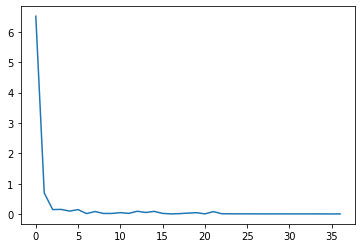

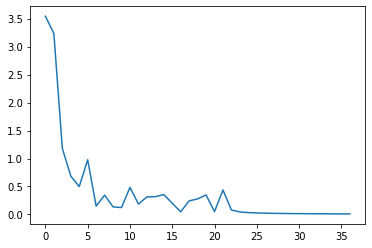

In [18]:
plt.figure()
plt.plot(lossvals)
plt.show()
plt.figure()
plt.plot(gradnormvals)
plt.show()